<a href="https://colab.research.google.com/github/AIAlchemy1/Generative-AI/blob/main/08_LLM_Fine_Tuning/LLM_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1. Interpretation with Logit Lens

Logit Lens is an interpretation technique introduced in [this post](https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens). The idea is the following. Imagine that we predict the continuation of a phrase "IPhone was developed by". We naturally expect to see "Apple", but we're also curious to see the "thought process" of an LLM, so we **feed outputs of intermediate layers (intermediate transformer blocks) to the classification head** to see *what would an LLM output if we cut its "thought process" short in the middle of it*. The general trend, as one moves from earlier to later layers, is
- "nonsense / not interpretable" (sometimes, in very early layers) -->
  - "shallow guesses" (words that are the right part of speech / register / etc) -->
- "better guesses" near the end.
However, it's not always like that, of course.

The author of the Logit Lens also created visualization tools and published a [jupyter notebook demo](https://colab.research.google.com/drive/1MjdfK2srcerLrAJDRaJQKO0sUiZ-hQtA?usp=sharing) with cool pictures, but in this task we'll need to reproduce the Logit Lens technique on our own.

**Note** If we're really short on compute, we can use GPT-2 instead of zephyr, but we risk losing all the fun and most of interpretability.

**Task 1.1.** Write a function

```
logit_lens(model, input_sentence, top_k)
```

that for each transformer block returns a dictionary

```
{
    'top_tokens' : [
        sorted list of top_k tokens,
        from most probable to least probable,
        according to the classification head
        ],
    'top_token_logits' : [logits of these tokens]
}
```

Hint:
- To get hidden states of a model we'll need to use `model(**encoded_input, output_hidden_states=True)` instead of `model.generate`


Here is how it should work:

In [ ]:
!pip install -q transformers
!pip install -q accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('stabilityai/stablelm-zephyr-3b')
model = AutoModelForCausalLM.from_pretrained(
    'stabilityai/stablelm-zephyr-3b',
    trust_remote_code=True,
    device_map="auto"
)

prompt = [{'role': 'user', 'content': 'List 3 synonyms for the word "tiny"'}]
inputs = tokenizer.apply_chat_template(
    prompt,
    add_generation_prompt=True,
    return_tensors='pt'
)

tokens = model.generate(
    inputs.to(model.device),
    max_new_tokens=1024,
    temperature=0.8,
    do_sample=True
)

print(tokenizer.decode(tokens[0], skip_special_tokens=False))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/5.21k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.59G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


<|user|>
List 3 synonyms for the word "tiny"<|endoftext|>
<|assistant|>
1.élan (slang)
2.petite (feminine)
3.small<|endoftext|>


In [ ]:
import numpy as np
import torch
from transformers import AutoTokenizer

def logit_lens(model, input_sentence, top_k=5):
    # Tokenize the input sentence
    tokenizer = AutoTokenizer.from_pretrained('stabilityai/stablelm-zephyr-3b')
    inputs = tokenizer(input_sentence, return_tensors="pt")

    # Move the inputs to the same device as the model
    inputs = inputs.to(model.device)

    # Pass the tokens through the model to get the logits
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits

    # Get the probabilities from the logits
    probs = torch.nn.functional.softmax(logits, dim=-1)

    # Get the top k tokens and their probabilities
    top_k_probs, top_k_tokens = torch.topk(probs, top_k, dim=-1)

    # Flatten the tensor and convert it to a list of integers
    top_k_tokens = top_k_tokens.flatten().tolist()

    # Decode the tokens back into words
    top_k_words = [tokenizer.decode([token]) for token in top_k_tokens]

    # Convert tensor to numpy array and then to list
    top_k_probs = top_k_probs.flatten().cpu().numpy().tolist()

    return list(zip(top_k_words, top_k_probs))

In [ ]:
result = logit_lens(model, "IPhone was developed by", top_k=5)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
result[-5:]

[(' Apple', 0.9472056031227112),
 (' a', 0.031474072486162186),
 (' the', 0.003716561710461974),
 (' IBM', 0.00304100732319057),
 (' an', 0.0029841407667845488)]

As we see, "Apple" appears as the most probable token in the last two layers.

**Task 1.2**

Now we'll use Logit Lens to investigate how transformers deal with redefinition.

Use Logit Lens on the sentence

```
"In this text the word IPhone means Windows operating system. IPhone was developed by"
```

Look at the most probable tokens for all layers. A good LLM knows that IPhone was developed by Apple through *memorization*. However, *in-context learning* will press it to output Microsoft. Check in which layers the most probable token is Microsoft and in which it is Apple.

Perform experiments with 9 other sentences with redefinition. Can we observe a pattern of competition between memorization and in-context learning?

In [ ]:
import torch
from transformers import AutoTokenizer

def logit_lens(model, input_sentence, layer_idx, top_k=5):
    # Tokenize the input sentence
    tokenizer = AutoTokenizer.from_pretrained('stabilityai/stablelm-zephyr-3b')
    inputs = tokenizer(input_sentence, return_tensors="pt")

    # Move the inputs to the same device as the model
    inputs = inputs.to(model.device)

    # Pass the tokens through the model to get the hidden states
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    hidden_states = outputs.hidden_states

    # Get the logits for the specified layer
    logits = hidden_states[layer_idx]

    # Get the probabilities from the logits
    probs = torch.nn.functional.softmax(logits, dim=-1)

    # Get the top k tokens and their probabilities
    top_k_probs, top_k_tokens = torch.topk(probs, top_k, dim=-1)

    # Flatten the tensor and convert it to a list of integers
    top_k_tokens = top_k_tokens.flatten().tolist()

    # Decode the tokens back into words
    top_k_words = [tokenizer.decode([token]) for token in top_k_tokens]

    # Convert tensor to numpy array and then to list
    top_k_probs = top_k_probs.flatten().cpu().numpy().tolist()

    return list(zip(top_k_words, top_k_probs))

In [ ]:
sentence = "In this text the word IPhone means Windows operating system. IPhone was developed by"
for layer_idx in range(model.config.num_hidden_layers):
    print(f"Layer {layer_idx}:")
    print(logit_lens(model, sentence, layer_idx))
    print()

Layer 0:


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('ier', 0.0004038846818730235), ('yl', 0.00040309663745574653), ('ript', 0.0004018192703370005), ('AC', 0.00040147604886442423), ('\x1e', 0.00040015499689616263), ('AC', 0.0004079891077708453), ('ript', 0.0004035313322674483), (' though', 0.000402891484554857), ('for', 0.0004015167651232332), (' true', 0.00040107587119564414), (').', 0.0004024695954285562), ('ire', 0.0004022240173071623), ('put', 0.000401439203415066), (' j', 0.0004002159694209695), ('uc', 0.0004001671331934631), (' though', 0.00041626900201663375), ('\\]', 0.00040961531340144575), (' treatment', 0.00040951528353616595), (' ab', 0.0004069240821991116), (' [@', 0.00040573367732577026), ('AC', 0.00040061501204036176), ('usion', 0.00040061501204036176), ('mu', 0.00040051722317002714), (' top', 0.0003996381419710815), ('ace', 0.00039949180791154504), ('AC', 0.0004137893265578896), (' best', 0.0004008625983260572), ('m', 0.0004005691152997315), (' complet', 0.000400275836000219), ('\x01', 0.000400275836000219), (' look', 0

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[(' though', 0.0010163241531699896), ('AC', 0.0005943719297647476), ('ful', 0.0004822243645321578), ('ts', 0.000448944658273831), ('\n', 0.00044588244054466486), (' though', 0.0007422598428092897), ('AC', 0.0005958924302831292), ('ological', 0.00042019219836220145), ('�', 0.00041891480213962495), (' read', 0.00041831526323221624), (' though', 0.0006919909501448274), ('AC', 0.0005059723043814301), ('etic', 0.0004662816063500941), (' similar', 0.00045869697351008654), ('ms', 0.0004243979346938431), (' though', 0.000700358476024121), ('AC', 0.0006342288106679916), ('se', 0.00042076868703588843), ('M', 0.0004186166333965957), (' air', 0.0004152584879193455), (' though', 0.0006855034735053778), ('AC', 0.0005302755744196475), (' similar', 0.0004676294338423759), ('etic', 0.000453170039691031), (',', 0.0004197322705294937), (' though', 0.0007154287886805832), ('AC', 0.0006054032128304243), (' why', 0.00043198169441893697), (' leg', 0.0004219850816298276), (' complet', 0.00041892568697221577),

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[(' though', 0.8253530859947205), ('\n', 0.07031140476465225), ('ful', 0.00043677890789695084), ('ts', 0.00014398722851183265), ('name', 6.55666517559439e-05), (' though', 0.0011097417445853353), ('AC', 0.0005572344525717199), (' air', 0.0005090232589282095), ('ological', 0.00046798819676041603), ('our', 0.00045268525718711317), (' though', 0.0008399335201829672), (' similar', 0.0005408626748248935), ('etic', 0.0005035022622905672), ('AC', 0.0004685747262556106), (' under', 0.00046473118709400296), ('\n', 0.857668936252594), (' though', 0.142331063747406), (' treatment', 8.904098704014263e-13), ('name', 8.737409125207651e-13), ('ts', 8.447244639886442e-13), (' though', 0.0007431106641888618), (' similar', 0.0005764754605479538), ('AC', 0.0005262629711069167), ('etic', 0.0005224442575126886), ('ate', 0.0004649768816307187), (' though', 0.0009831814095377922), ('AC', 0.0006069221417419612), (' why', 0.0004582620458677411), (' leg', 0.0004365336790215224), ('br', 0.00043505110079422593), 

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[(' though', 0.9862663745880127), ('\n', 0.01249729935079813), ('ful', 6.222774572961498e-06), ('ts', 4.731202807306545e-06), ('name', 8.412169449911744e-07), (' though', 0.002894763136282563), ('\n', 0.0005746880196966231), (' air', 0.0005562981241382658), ('AC', 0.0005145559553056955), ('ological', 0.0005093708168715239), (' though', 0.00161697156727314), (' similar', 0.0005836552008986473), ('etic', 0.0005205500638112426), ('\n', 0.0004994088085368276), (' under', 0.0004926170804537833), ('\n', 0.6706891655921936), (' though', 0.3293108344078064), ('ts', 2.2670760939109275e-13), ('name', 2.2169766022983595e-13), ('gr', 1.8784363712935626e-13), (' though', 0.0011923661222681403), (' similar', 0.000624299980700016), ('etic', 0.0005336672766134143), ('AC', 0.0005014727939851582), ('ate', 0.000472029933007434), (' though', 0.0014398818602785468), ('AC', 0.0005954333464615047), ('\n', 0.0004903491353616118), (' why', 0.00047272854135371745), ('br', 0.0004603553388733417), (' though', 0.0

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), (' though', 0.003237247234210372), (' air', 0.0006080061430111527), ('AC', 0.0005670571699738503), ('ological', 0.0005293986760079861), ('ety', 0.0005021175602450967), (' though', 0.0022958433255553246), (' similar', 0.0006231319275684655), ('etic', 0.0005742900539189577), ('\n', 0.0005528376786969602), ('ety', 0.0005184077890589833), (' though', 0.004336543846875429), (' air', 0.0006345169967971742), ('AC', 0.0005354281165637076), ('}{', 0.0004861900524701923), ('om', 0.00048444149433635175), (' though', 0.0014601959846913815), (' similar', 0.0007265399908646941), ('etic', 0.0005536281387321651), ('AC', 0.0005373082240112126), ('ate', 0.0005170427612029016), (' though', 0.0016220611287280917), ('AC', 0.000638019701000303), (' why', 0.0005061118281446397), ('our', 0.0004902688669972122), ('tern', 0.00048415939090773463), (' though', 0.0006808926118537784), ('ators', 0.0006005184259265661), ('No', 0.0005

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), (' though', 0.002993938745930791), (' air', 0.0006260685040615499), ('AC', 0.0005874668131582439), ('ological', 0.0005735219456255436), ('ety', 0.00051604158943519), (' though', 0.0024860547855496407), (' similar', 0.0006734671769663692), ('etic', 0.0006160004995763302), ('att', 0.0005271707195788622), ('put', 0.0005214386619627476), (' though', 0.0029414654709398746), ('AC', 0.0006215024623088539), (' air', 0.0005753201548941433), ('i', 0.0005402620299719274), ('ution', 0.0004968260182067752), (' though', 0.001899553695693612), (' similar', 0.0008367919945158064), ('etic', 0.0006252105231396854), ('ate', 0.0005354710156098008), ('AC', 0.000525851093698293), (' though', 0.0030777915380895138), ('AC', 0.0006121285259723663), (' why', 0.0005605959449894726), (' issue', 0.0004920330829918385), ('our', 0.0004890061682090163), (' though', 0.0022986638359725475), ('ators', 0.0007355338311754167), (' why', 0.0

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), (' though', 0.004676360636949539), (' air', 0.0006799738039262593), ('AC', 0.0006187430117279291), ('ety', 0.0005938761169090867), ('ological', 0.0005890167667530477), (' though', 0.0026989353355020285), (' similar', 0.0007114466279745102), ('etic', 0.000705217884387821), ('ms', 0.000552734883967787), ('ety', 0.0005361916264519095), (' though', 0.0028825821354985237), ('AC', 0.0006985212094150484), (' air', 0.0005880278185941279), ('put', 0.000548212556168437), ('raw', 0.0005453319754451513), (' though', 0.001034185872413218), (' similar', 0.000981440651230514), ('etic', 0.0006267064018175006), ('AC', 0.0006073887343518436), ('very', 0.0005745748057961464), (' though', 0.0015072227688506246), ('AC', 0.0007189419120550156), (' why', 0.0005549250636249781), (' method', 0.000522504560649395), (' issue', 0.0005173583631403744), (' though', 0.0016132013406604528), ('ators', 0.0009167250245809555), ('etic', 0

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), (' though', 0.0030529580544680357), ('\n', 0.0008117904071696103), (' air', 0.0007541117374785244), ('ological', 0.0006836489192210138), ('ety', 0.0006374348886311054), (' though', 0.003663144074380398), ('\n', 0.0015995812136679888), ('etic', 0.0007912765140645206), (' similar', 0.0007372808759100735), (' ab', 0.0006537296576425433), (' though', 0.0012632999569177628), ('AC', 0.0008010541787371039), ('raw', 0.0006450676009990275), (' air', 0.0006048163049854338), ('put', 0.0005840005469508469), (' though', 0.001168599701486528), (' similar', 0.0010776640847325325), ('\n', 0.0007916072499938309), ('etic', 0.0006408437620848417), (' best', 0.0005876155919395387), (' though', 0.0008633416146039963), ('AC', 0.0007552984752692282), ('\n', 0.0006839466514065862), ('am', 0.0005340484785847366), (' method', 0.0005330130807124078), ('\n', 0.0015333793126046658), (' though', 0.0015113266417756677), ('ators', 0.0

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), (' though', 0.003279320430010557), ('\n', 0.0013772723032161593), (' air', 0.0009346961160190403), ('ety', 0.0007814686396159232), ('ological', 0.0007206785958260298), ('\n', 0.003305430756881833), (' though', 0.003287828527390957), ('etic', 0.0010271500796079636), (' similar', 0.0007808223599568009), ('put', 0.0006516119465231895), (' though', 0.0015399499097838998), ('\n', 0.0008880618843249977), ('AC', 0.0008021302637644112), ('ety', 0.0007157644722610712), (' air', 0.0006670909351669252), ('\n', 0.0014737793244421482), (' though', 0.001406351337209344), (' similar', 0.0011438721558079123), ('etic', 0.0007234917138703167), ('�', 0.0006626881076954305), (' though', 0.000898048747330904), ('AC', 0.0008783743833191693), ('\n', 0.0008144216844812036), (' why', 0.0006829283083789051), ('18', 0.0006103161140345037), ('\n', 0.0035415368620306253), (' though', 0.001577193383127451), ('ators', 0.0012897654669

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), (' though', 0.005285189021378756), ('\n', 0.0014087208546698093), (' air', 0.0010951112490147352), ('ological', 0.000768417667131871), ('ety', 0.0007111707236617804), ('\n', 0.004635448567569256), (' though', 0.0034450211096554995), ('etic', 0.001283567980863154), (' ab', 0.0009058174910023808), (' similar', 0.0008431845926679671), (' though', 0.0030125086195766926), ('\n', 0.001725142588838935), ('AC', 0.0007592562469653785), ('raw', 0.0007510744035243988), ('ety', 0.0007394372369162738), (' similar', 0.001387565629556775), ('\n', 0.001282242126762867), (' though', 0.0011225421912968159), ('etic', 0.0008247431833297014), (' sc', 0.0006988157401792705), ('\n', 0.0036235081497579813), (' though', 0.002178281545639038), (' why', 0.0008448947337456048), ('18', 0.0007942956872284412), ('AC', 0.000769894861150533), ('\n', 0.0063446587882936), (' though', 0.0015593282878398895), ('etic', 0.0014164565363898873

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), (' though', 0.007593794260174036), ('\n', 0.0016213605413213372), (' air', 0.0011972960783168674), ('ety', 0.0008277721935883164), ('ars', 0.0008240515599027276), ('\n', 0.004776687826961279), (' though', 0.00376777327619493), ('etic', 0.001515579642727971), (' ab', 0.0011319346958771348), ('put', 0.000873279816005379), (' though', 0.0036915999371558428), ('\n', 0.0017738101305440068), ('ety', 0.0007513821474276483), ('put', 0.0007477301987819374), ('AC', 0.0007311592344194651), (' though', 0.0017651780508458614), ('\n', 0.0013746884651482105), (' similar', 0.0013510986464098096), (' sc', 0.0007766670896671712), ('etic', 0.0007756126578897238), ('\n', 0.0010137264616787434), (' though', 0.0009478805004619062), ('18', 0.0008434957708232105), (' why', 0.000771673396229744), ('ars', 0.0007599831442348659), ('\n', 0.003188742557540536), ('ators', 0.0017399042844772339), ('etic', 0.001432399032637477), (' th

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), (' though', 0.00490428926423192), (' air', 0.0013009165413677692), ('\n', 0.000927217595744878), ('ars', 0.0008978372206911445), ('ety', 0.0007854431169107556), ('\n', 0.006457902491092682), (' though', 0.004128957167267799), ('etic', 0.001526338397525251), (' ab', 0.001461207284592092), ('put', 0.0009444757597520947), (' though', 0.004551906604319811), ('\n', 0.0020638201385736465), ('AC', 0.0008529460174031556), (' air', 0.0008042239933274686), ('lection', 0.0008036289946176112), (' though', 0.001439462648704648), (' similar', 0.0014285242650657892), ('\n', 0.0010087150149047375), (' sc', 0.000964521081186831), ('p', 0.0007430032128468156), ('\n', 0.0016226352890953422), (' though', 0.001519444165751338), ('18', 0.000996092101559043), ('ars', 0.0009850163478404284), (' why', 0.0008219977607950568), ('\n', 0.008059609681367874), ('ators', 0.002374140312895179), (' though', 0.00229241163469851), ('etic'

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), (' though', 0.014328183606266975), ('\n', 0.0021431308705359697), (' air', 0.0014930183533579111), ('ars', 0.0008786338148638606), ('ms', 0.0008308591204695404), ('\n', 0.007866578176617622), (' though', 0.006145210471004248), (' ab', 0.0016656327061355114), ('etic', 0.0015849346527829766), ('put', 0.0010717172408476472), (' though', 0.007805203553289175), ('\n', 0.002945002168416977), ('put', 0.0008994749514386058), (' air', 0.0007709151250310242), ('AC', 0.0007513576420024037), (' though', 0.0018939245492219925), (' similar', 0.001412845915183425), ('\n', 0.0013183722039684653), (' sc', 0.0010322339367121458), ('ploy', 0.0007998114451766014), ('\n', 0.0016979686915874481), (' though', 0.0016002404736354947), ('18', 0.001151114935055375), ('ars', 0.001018022419884801), (' why', 0.0008768991101533175), ('\n', 0.01793835125863552), (' though', 0.0032860643696039915), ('etic', 0.0028378257993608713), ('at

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), (' though', 0.014393935911357403), ('\n', 0.002137515926733613), (' air', 0.0016305866884067655), ('ars', 0.0010851852130144835), ('ms', 0.0010222839191555977), ('\n', 0.014047623611986637), (' though', 0.007906888611614704), (' ab', 0.001875370740890503), ('etic', 0.001589975319802761), ('put', 0.0011490605538710952), (' though', 0.01991286128759384), ('\n', 0.00926835648715496), ('span', 0.0009275197517126799), ('put', 0.0008998347329907119), (' air', 0.0008794637979008257), (' though', 0.0020667288918048143), (' similar', 0.001523943617939949), ('\n', 0.0011153004597872496), (' sc', 0.001076876069419086), (' However', 0.0008865849813446403), (' though', 0.0013793675461784005), ('ars', 0.0013249486219137907), ('\n', 0.0012290956219658256), ('18', 0.001126511488109827), (' why', 0.0009161362540908158), ('\n', 0.022680217400193214), (' though', 0.0035675240214914083), ('etic', 0.002970146480947733), ('a

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), (' though', 0.02484600804746151), ('\n', 0.002888467162847519), (' air', 0.0016259941039606929), ('ars', 0.0011164939496666193), ('ms', 0.0010739669669419527), ('\n', 0.01052878051996231), (' though', 0.008474444039165974), (' ab', 0.0021702067460864782), ('etic', 0.0019114745082333684), ('put', 0.0012557691661641002), (' though', 0.019451657310128212), ('\n', 0.003553868969902396), ('span', 0.0016684047877788544), (' air', 0.0010083626257255673), ('put', 0.000954855524469167), (' though', 0.0021237796172499657), (' similar', 0.0014519654214382172), ('\n', 0.0012733342591673136), (' sc', 0.00113359943497926), ('span', 0.0010226598242297769), ('\n', 0.0014454382471740246), (' though', 0.001258027390576899), ('ars', 0.001249120570719242), ('18', 0.001156929531134665), ('our', 0.0009442376322112978), ('\n', 0.020776119083166122), ('etic', 0.00407328549772501), ('ators', 0.003781237406656146), (' though', 0

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), (' though', 0.04536351561546326), ('\n', 0.0051435320638120174), ('span', 0.001846219995059073), (' air', 0.0017465766286477447), ('ars', 0.0014373465673997998), ('\n', 0.017667310312390327), (' though', 0.011995186097919941), (' ab', 0.002511520404368639), ('etic', 0.0025082796346396208), ('span', 0.0014915169449523091), (' though', 0.060751114040613174), ('\n', 0.010900002904236317), ('span', 0.0055511523969471455), (' air', 0.0011752148857340217), ('put', 0.0009134684223681688), ('\n', 0.00804845243692398), (' though', 0.005815885495394468), ('span', 0.003301942255347967), (' similar', 0.0018996658036485314), (' ab', 0.001200266880914569), ('\n', 0.002792441053315997), (' though', 0.0019928745459765196), ('ars', 0.0012055067345499992), ('18', 0.0011927896412089467), (' why', 0.0011186813935637474), ('\n', 0.13041844964027405), (' though', 0.006081019062548876), ('etic', 0.004605352878570557), ('ators

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), (' though', 0.08876189589500427), ('\n', 0.00939283799380064), ('span', 0.0034927218221127987), (' air', 0.0015906690387055278), ('ms', 0.0013765284093096852), ('\n', 0.07762475311756134), (' though', 0.026225438341498375), ('span', 0.0035484791733324528), (' ab', 0.003152125747874379), ('etic', 0.002541981404647231), (' though', 0.20023252069950104), ('span', 0.03213046118617058), ('\n', 0.025535646826028824), (' air', 0.0012144449865445495), (' top', 0.000795471656601876), ('\n', 0.02479042299091816), (' though', 0.016249755397439003), ('span', 0.013900299556553364), (' similar', 0.0016980834770947695), (' ab', 0.0013696362730115652), ('\n', 0.017194636166095734), (' though', 0.0048014200292527676), ('span', 0.0033727979753166437), (' why', 0.0014163004234433174), ('ok', 0.0013811311218887568), ('\n', 0.38216403126716614), (' though', 0.005401980597525835), ('etic', 0.004303178749978542), ('span', 0.0

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), (' though', 0.05200883746147156), ('span', 0.013938222080469131), ('\n', 0.004832240752875805), ('ms', 0.001822176855057478), (' air', 0.0017879146616905928), ('\n', 0.05085957422852516), (' though', 0.020853180438280106), ('span', 0.011074786074459553), (' ab', 0.004300151020288467), ('etic', 0.0040791695937514305), ('span', 0.18950118124485016), (' though', 0.15612712502479553), ('\n', 0.010743013583123684), (' air', 0.0012403458822518587), ('ety', 0.0008201606688089669), ('span', 0.05947937071323395), ('\n', 0.022982275113463402), (' though', 0.017067832872271538), (' similar', 0.0017998113762587309), (' ab', 0.0017910971073433757), ('\n', 0.01018744707107544), ('span', 0.00807681679725647), (' though', 0.002818679204210639), ('ars', 0.0015448775375261903), (' why', 0.001304365461692214), ('\n', 0.45346003770828247), ('span', 0.012300657108426094), ('etic', 0.00354622770100832), ('ators', 0.003064092

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), ('span', 0.1485733538866043), (' though', 0.07812375575304031), ('\n', 0.010813875123858452), ('ms', 0.0021228960249572992), (' air', 0.001491402625106275), ('\n', 0.20836029946804047), ('span', 0.07897163182497025), (' though', 0.02712288685142994), (' ab', 0.004026663023978472), ('etic', 0.00339896441437304), ('span', 0.770042896270752), (' though', 0.06377924978733063), ('\n', 0.00943693146109581), (' air', 0.0002949924091808498), ('ety', 0.000260568835074082), ('span', 0.27038946747779846), ('\n', 0.02184896357357502), (' though', 0.012008020654320717), (' ab', 0.0014119113329797983), ('return', 0.0013273423537611961), ('span', 0.03553326427936554), ('\n', 0.013514806516468525), (' though', 0.0020188004709780216), (' why', 0.0013448212994262576), ('ars', 0.0012129226233810186), ('\n', 0.8090454339981079), ('span', 0.031516022980213165), ('ators', 0.0011541388230398297), ('etic', 0.001094570965506136

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), ('span', 0.4444446861743927), (' though', 0.09388881921768188), ('\n', 0.0049131023697555065), ('ms', 0.0012245363323017955), (' air', 0.0011442953255027533), ('span', 0.1748315542936325), ('\n', 0.10221211612224579), (' though', 0.028080709278583527), (' ab', 0.00450059212744236), ('etic', 0.0030783251859247684), ('span', 0.9507654309272766), (' though', 0.011936340481042862), ('\n', 0.0007024701917544007), ('#', 6.109272362664342e-05), (' air', 6.0468966694315895e-05), ('span', 0.3853631317615509), (' though', 0.00550101650878787), ('\n', 0.0031978862825781107), (' ab', 0.0011547256726771593), (' used', 0.0010787427891045809), ('span', 0.041300784796476364), ('ars', 0.0012887130724266171), (' due', 0.0012798759853467345), (' why', 0.0012627985561266541), (' appro', 0.0012184132356196642), ('\n', 0.5829142332077026), ('span', 0.10681971907615662), ('etic', 0.002247563563287258), ('ators', 0.00218724622

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), ('span', 0.9742493033409119), (' though', 0.009491311386227608), ('\n', 0.00021765146811958402), ('ms', 3.8976788346190006e-05), ('ou', 3.8530331949004903e-05), ('span', 0.8745131492614746), ('\n', 0.009645471349358559), (' though', 0.008849270641803741), ('etic', 0.0005900273099541664), (' ab', 0.0005022815894335508), ('span', 0.9987174272537231), (' though', 0.0005566845065914094), ('\n', 3.422887675696984e-05), ('ety', 1.1355468814144842e-06), ('#', 1.0562941952230176e-06), ('span', 0.9662196636199951), (' though', 0.0011461526155471802), ('\n', 0.0008804886601865292), (' going', 7.378613372566178e-05), (' used', 5.816896737087518e-05), ('span', 0.7290809750556946), (' though', 0.0010030505945906043), ('\n', 0.0006633319426327944), ('ars', 0.00039561642915941775), (' why', 0.0003786090819630772), ('span', 0.48909440636634827), ('\n', 0.3751233220100403), ('etic', 0.0011343271471560001), ('ators', 0.0

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), ('span', 0.9994537234306335), (' though', 0.00032847386319190264), ('\n', 1.4285871657193638e-05), ('ms', 6.396605840564007e-07), ('ou', 5.446646014206635e-07), ('span', 0.9838115572929382), ('\n', 0.00237572961486876), (' though', 0.0016068830154836178), ('etic', 6.21284416411072e-05), (' ab', 5.057450835010968e-05), ('span', 0.9998937845230103), (' though', 6.251281592994928e-05), ('\n', 3.7763275031466037e-06), ('ety', 6.96885109618961e-08), ('#', 6.513611339187264e-08), ('span', 0.99552983045578), (' though', 0.00020162004511803389), ('\n', 0.0001428167161066085), (' used', 8.677183359395713e-06), ('une', 8.586688636569306e-06), ('span', 0.8990294337272644), (' though', 0.0005395868793129921), ('\n', 0.0003320315445307642), (' appro', 0.0001599324750714004), (' process', 0.00015120198077056557), ('span', 0.7578883767127991), ('\n', 0.20027515292167664), ('etic', 0.0003729233576450497), ('ators', 0.0

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), ('span', 0.9997280240058899), (' though', 0.00017188183846883476), ('\n', 5.102904651721474e-06), ('ety', 3.750091650545073e-07), ('ms', 3.2058497367870586e-07), ('span', 0.9974253177642822), ('\n', 0.0007475190795958042), (' though', 0.0006798602407798171), ('etic', 7.821920917194802e-06), (' ab', 6.60702562527149e-06), ('span', 0.9999878406524658), (' though', 7.3981732384709176e-06), ('\n', 2.3574862950681563e-07), ('#', 8.735531409342912e-09), ('ety', 8.424370534498848e-09), ('span', 0.9992642998695374), (' though', 5.994186722091399e-05), ('\n', 5.8524568885331973e-05), (' ab', 1.6261801647488028e-06), ('une', 1.4695629033667501e-06), ('span', 0.9751611351966858), (' though', 0.0001653079962125048), ('\n', 0.00011381721560610458), (' process', 4.467738472158089e-05), ('         ', 4.225180600769818e-05), ('span', 0.9475759267807007), ('\n', 0.05051330849528313), ('etic', 2.3738810341455974e-05), ('

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), ('span', 0.9999971389770508), (' though', 1.5619024225088651e-06), ('\n', 8.035404874817687e-08), ('ety', 5.6133702130978236e-09), ('ms', 5.471624930919461e-09), ('span', 0.9994840621948242), ('\n', 0.00012234751193318516), (' though', 0.00011256130528636277), ('etic', 2.3154125301516615e-06), (' ab', 1.4877163039273e-06), ('span', 0.9999997615814209), (' though', 1.1977168412613537e-07), ('\n', 5.904731370520722e-09), ('ety', 2.3438070928527566e-10), (' hand', 2.2988068393292593e-10), ('span', 0.9999364614486694), ('\n', 6.759390544175403e-06), (' though', 3.7689833334297873e-06), ('une', 1.5482908111152938e-07), (' ab', 1.210500499837508e-07), ('span', 0.9996458292007446), (' though', 4.220844857627526e-06), ('\n', 3.81036511498678e-06), (' process', 6.796692559873918e-07), ('une', 6.730757036166324e-07), ('span', 0.9872744083404541), ('\n', 0.011856764554977417), ('etic', 1.0881191883527208e-05), ('a

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), ('span', 1.0), (' though', 3.311403773409438e-08), ('\n', 1.4463409359066759e-09), ('ms', 1.0727643079411209e-10), ('ety', 8.670095891227803e-11), ('span', 0.9999942779541016), ('\n', 4.203384378342889e-06), (' though', 4.436037670529913e-07), ('etic', 1.2139735439120614e-08), (' ab', 4.406442322135717e-09), ('span', 1.0), (' though', 9.73352731747923e-10), ('\n', 9.314597010368075e-11), (' hand', 1.3412086111858068e-12), ('ety', 9.80620424272105e-13), ('span', 0.9999997615814209), ('\n', 1.453169318210712e-07), (' though', 8.944946117139807e-09), ('une', 3.4741712284791504e-10), ('ploy', 2.1879585643258537e-10), ('span', 0.999996542930603), ('\n', 9.141304246895743e-08), (' though', 6.458509460571804e-08), ('une', 1.0249257442751514e-08), (' process', 7.87612908226265e-09), ('span', 0.999357283115387), ('\n', 0.0006334923091344535), ('etic', 1.4703115880365658e-07), (' though', 8.182929889244406e-08), 

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), ('span', 1.0), (' though', 1.5324059798871303e-09), ('\n', 2.767262634317813e-11), ('ms', 4.825006279934874e-12), (' human', 4.261465746252524e-12), ('span', 0.9999997615814209), ('\n', 1.8073673402341228e-07), (' though', 4.636650885458948e-08), ('etic', 4.715019485956873e-10), (' ab', 1.9792249783545657e-10), ('span', 1.0), (' though', 3.263170983425212e-11), ('\n', 1.6596563533199937e-12), ('ething', 2.8637780758985e-14), ('ety', 2.5252898188353468e-14), ('span', 1.0), ('\n', 4.345107829095696e-09), (' though', 7.337979668342598e-10), (' ab', 2.0327795002827997e-11), ('une', 1.748943004309389e-11), ('span', 0.9999995231628418), (' though', 1.4111101620528643e-08), ('\n', 9.83861259129526e-09), ('une', 1.4637465683975392e-09), (' happ', 1.301721619384466e-09), ('span', 0.9994311928749084), ('\n', 0.0005490820622071624), ('etic', 2.5863670316539356e-07), (' though', 2.550860074279626e-07), ('amma', 1.2

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), ('span', 1.0), (' though', 1.5563976496490994e-10), ('\n', 7.341347148248634e-12), ('ms', 4.463344028138999e-13), (' human', 4.381559134611357e-13), ('span', 1.0), ('\n', 2.485127126305997e-08), (' though', 6.82898237958085e-10), ('etic', 5.093657266808105e-12), ('urs', 2.738059562065742e-12), ('span', 1.0), (' though', 1.3242808542465734e-13), ('\n', 4.7477331717752855e-14), ('ething', 1.2154676624148914e-16), ('ety', 1.0411288927563982e-16), ('span', 1.0), ('\n', 7.886325620320989e-11), (' though', 1.291048431356634e-12), ('une', 3.122447030210092e-14), (' ab', 2.4295344382141426e-14), ('span', 1.0), ('\n', 1.1026060064978083e-09), (' though', 4.683846088759935e-10), ('une', 6.334339303082359e-11), (' Cal', 4.011273604942467e-11), ('span', 0.9998831748962402), ('\n', 0.0001139280793722719), ('etic', 4.62664075939756e-08), (' though', 3.021018102344897e-08), ('amma', 2.5223503286042614e-08), ('span', 1

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), ('span', 1.0), (' though', 6.563426017958118e-13), ('\n', 1.8322655878969495e-14), (' human', 2.103516327255409e-15), ('ms', 1.9520880121100216e-15), ('span', 1.0), ('\n', 9.374000881079425e-11), (' though', 2.992425317954739e-12), ('etic', 1.8649502176392406e-14), ('ru', 1.606770848371162e-14), ('span', 1.0), ('\n', 3.806676907162908e-17), (' though', 3.4815098922625975e-17), ('ething', 5.155448404176494e-20), ('�', 4.6631240745168566e-20), ('span', 1.0), ('\n', 4.2392912097399815e-13), (' though', 5.665796184403963e-15), (' ab', 1.4004309383843628e-16), ('une', 1.3773105123445666e-16), ('span', 1.0), ('\n', 1.0517924725617078e-10), (' though', 9.261645617097969e-11), ('une', 1.679675495913635e-11), ('ide', 1.0127995664355183e-11), ('span', 0.9999860525131226), ('\n', 1.3227442650531884e-05), ('etic', 1.7821234266079955e-08), (' though', 1.0089847179983735e-08), ('amma', 8.231450188134204e-09), ('span'

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), ('span', 1.0), (' though', 1.0144809715379819e-16), ('\n', 5.947331989560723e-17), (' human', 4.194518890428236e-19), ('ou', 3.3676789728900035e-19), ('span', 1.0), ('\n', 1.4343231463653794e-11), (' though', 1.6265523541773852e-13), ('etic', 1.0925019306982941e-15), ('ru', 9.846166147559347e-16), ('span', 1.0), ('\n', 1.3010487074396229e-18), (' though', 2.453894359660264e-19), ('ething', 4.39108505056348e-22), ('�', 3.7460495180178524e-22), ('span', 1.0), ('\n', 1.3376466275784316e-13), (' though', 1.5783544176500852e-15), (' \n', 3.5065010038012946e-17), ('une', 3.4263180856873443e-17), ('span', 1.0), (' though', 8.814725858952155e-12), ('\n', 8.718979531419091e-12), ('une', 1.3077852602932927e-12), (' happ', 8.627197263869069e-13), ('span', 0.9999996423721313), ('\n', 3.7299955124581174e-07), ('etic', 9.25449022970426e-11), ('amma', 6.734538621211428e-11), (' though', 5.75554499893105e-11), ('span',

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), ('span', 1.0), ('\n', 1.0283900218098671e-18), (' though', 8.508530741182234e-19), (' human', 1.1777591431986075e-20), ('ms', 7.160577022064081e-21), ('span', 1.0), ('\n', 7.42117820104124e-14), (' though', 7.498798563910082e-17), ('ru', 1.0831882558496676e-18), ('ok', 1.0539349100891532e-18), ('span', 1.0), ('\n', 1.0306044877072482e-19), (' though', 5.939271504817245e-21), ('�', 1.7271527340466e-23), ('aking', 1.461410265310065e-23), ('span', 1.0), ('\n', 5.810717486569425e-16), (' though', 1.1989388442890864e-18), (' ab', 2.6422009921321948e-20), ('une', 2.4969902433920778e-20), ('span', 1.0), ('\n', 9.454645454130134e-14), (' though', 3.405779889879834e-14), ('ide', 5.929012096279711e-15), ('une', 5.782483443217716e-15), ('span', 1.0), ('\n', 3.646629886944197e-09), ('etic', 6.677908009553035e-13), ('amma', 5.795518687352896e-13), (' though', 2.4208624471375173e-13), ('span', 1.0), (' though', 1.494

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), ('span', 1.0), (' though', 5.396039822620259e-22), ('\n', 5.314733885494174e-22), (' human', 1.7569499037029702e-23), ('ms', 1.5557047025773052e-23), ('span', 1.0), ('\n', 3.5479730471529554e-15), (' though', 4.213848622758255e-17), ('ru', 2.9384077520425336e-18), ('etic', 1.9056431855631798e-18), ('span', 1.0), ('\n', 3.7186703648081657e-22), (' though', 1.4382209101401882e-23), ('�', 1.3582081980555344e-25), ('aking', 1.294573500540717e-25), ('span', 1.0), ('\n', 4.8054319841161745e-17), (' though', 6.834267550538152e-19), ('31', 4.3337446320073623e-20), ('�', 2.743914157555527e-20), ('span', 1.0), ('\n', 1.3643308573935275e-17), (' though', 5.265384274801183e-18), ('ide', 3.3629306976800077e-18), ('ine', 1.783186540500217e-18), ('span', 1.0), ('\n', 1.2540849435305201e-11), ('etic', 2.213074321510359e-14), ('amma', 1.5213646857061003e-14), ('ok', 9.90036842112886e-15), ('span', 1.0), (' though', 1.04

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[('\n', 1.0), ('!', 0.0), ('<|endoftext|>', 0.0), ('"', 0.0), ('<|padding|>', 0.0), ('span', 1.0), ('\n', 2.6446635803244285e-26), (' though', 4.723095706611842e-28), ('�', 1.63456382719129e-28), ('ou', 1.5228198069998628e-28), ('span', 1.0), ('\n', 8.954115747317445e-20), ('ok', 2.575769190194943e-22), (' though', 1.196930321120682e-22), ('ru', 6.165360706327819e-23), ('span', 1.0), ('\n', 5.605249313155153e-26), (' though', 4.879031031971585e-28), (' prob', 2.0279241849764458e-29), ('aking', 2.0113753310027446e-29), ('span', 1.0), ('\n', 4.728593319737155e-21), (' though', 1.4240649589681782e-23), ('31', 4.340088664028924e-24), (' take', 2.649149536469581e-24), ('span', 1.0), ('ide', 1.9615331299904883e-20), ('ok', 1.96131631819712e-20), (' happ', 1.2554362494787385e-20), (' process', 1.1676713363552252e-20), ('span', 1.0), ('\n', 6.364782383796552e-16), ('ok', 2.3231258315710925e-17), ('amma', 1.487143520992133e-17), ('etic', 4.794772272998326e-18), ('span', 1.0), (' though', 1.5359

# Task 2. Rotary embeddings

**Task 2.1**

In this task we'll need to code rotary embeddings. Actually, they are not just embeddings, but rather a transformation that is applied to queries and keys. It works like that:

$$f_q(x_m, m) = x_mW_QR^d_{\Theta, m},\quad f_k(x_n, n) = x_nW_KR^d_{\Theta, n},$$
where
$$R^d_{\Theta, m} =
\begin{pmatrix}
\cos{m\theta_1} & \sin{m\theta_1} & 0 & 0 & \dots & 0 & 0\\
-\sin{m\theta_1} & \cos{m\theta_1} & 0 & 0 & \dots & 0 & 0\\
0 & 0 & \cos{m\theta_2} & \sin{m\theta_2} & \dots & 0 & 0\\
0 & 0 & -\sin{m\theta_2} & \cos{m\theta_2} & \dots & 0 & 0\\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots\\
0 & 0 & 0 & 0 & \dots & \cos{m\theta_{d/2}} & \sin{m\theta_{d/2}}\\
0 & 0 & 0 & 0 & \dots & -\sin{m\theta_{d/2}} & \cos{m\theta_{d/2}}\\
\end{pmatrix},$$
where the parameters $\Theta$ are set to
$$\theta_i = b^{-2(i-1)/d}$$
for some base $b$ (default $10000$).

As we see, the transformation is the same for both keys and values, so we just need one transformation that takes a tensor of size `[batch_size, num_heads, seq_len, head_size]` and "rotates" it outputting a tensor of the same size.

Please try our best to make calculations efficient and don't forget to use `torch` (and not `numpy`) and load all the tensors to the right `device`.

Hints:
1. As we've discussed in the longread, rotary embeddings can be $f_{q,k}(x_m, m) = x_mW_{Q,K}R^d_{\Theta, m}$ of $f_{q,k}(x_m, m) = \left(R^d_{\Theta, m}\right)^TW_{Q,K}x_m$ depending on whether $x_m$ is a row vector (first formula) or a column vector (second formula). In our case the input dimension is `[batch_size, num_heads, seq_len, head_size]`, so after we choose a particular batch element and a particular attention head, $x_m$ has dimension `(1, head_size)` which is a row.
2. Recalculating all the $\theta_i = b^{-2(i-1)/d}$, sines and cosines takes much time. A good ideas it to cache them as soon as they are needed. we can either calculate $R^d_{\Theta, m}$ for large sequence length right at the initialization or:
  - At initialization cache $R^d_{\Theta, m}$ for moderately short sequences;
  - When we encounter a longer sequence, recalculate and cache again.
3. We don't need to store all the matrix $R^d_{\Theta, m}$ because it has too many zeros. Actually, we can just store sines and cosines and do $x \mapsto xR^d_{\Theta, m}$ in linear time:
$$xR^d_{\Theta, m} = \begin{pmatrix}
x_1\cos{m\theta_1} - x_2\sin{m\theta_1}\\
x_1\sin{m\theta_1} + x_2\cos{m\theta_1}\\
x_3\cos{m\theta_2} - x_4\sin{m\theta_2}\\
x_3\sin{m\theta_2} + x_4\cos{m\theta_2}\\
\vdots
\end{pmatrix} =
\begin{pmatrix}x_1\\x_2\\x_3\\x_4\\\vdots\end{pmatrix}\otimes
\begin{pmatrix}\cos{m\theta_1}\\\cos{m\theta_1}\\\cos{m\theta_2}\\\cos{m\theta_2}\\\vdots\end{pmatrix} +
\begin{pmatrix}-x_2\\x_1\\-x_4\\x_2\\\vdots\end{pmatrix}\otimes
\begin{pmatrix}\sin{m\theta_1}\\\sin{m\theta_1}\\\sin{m\theta_2}\\\sin{m\theta_2}\\\vdots\end{pmatrix}
$$


In [ ]:
import math
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer
from typing import Optional

class RotaryEmbedding(nn.Module):
    def __init__(
        self,
        dim: int,
        max_position_embeddings: int,
        base: int = 10_000,
        device: Optional[torch.device] = None,
    ):
        super().__init__()
        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.pe = self.generate_positional_embeddings().to(self.device)

    def generate_positional_embeddings(self):
        position = torch.arange(0, self.max_position_embeddings).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.dim, 2) * -(math.log(10000.0) / self.dim))
        pe = torch.zeros(self.max_position_embeddings, self.dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).unsqueeze(1)
        return pe

    def forward(self, x: torch.Tensor, seq_len: Optional[int] = None):
        pe = self.pe[:, :, :x.size(2), :x.size(-1)].to(x.device)  # Move pe to the same device as x
        x = x + pe
        return x

# Initialize the RotaryEmbedding
rotary_embedding = RotaryEmbedding(dim=768, max_position_embeddings=512, device=torch.device('cuda'))

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('stabilityai/stablelm-zephyr-3b')
model = AutoModelForCausalLM.from_pretrained('stabilityai/stablelm-zephyr-3b')

# Prepare the inputs
prompt = [{'role': 'user', 'content': 'List 3 synonyms for the word "tiny"'}]
inputs = tokenizer(prompt[0]['content'], return_tensors='pt')

# Reshape inputs['input_ids'] to have the expected dimensions
inputs_reshaped = inputs['input_ids'].unsqueeze(1).unsqueeze(-1).expand(-1, model.config.num_attention_heads, -1, model.config.hidden_size // model.config.num_attention_heads)

# Apply the rotary embedding
inputs_embedded = rotary_embedding(inputs_reshaped)

# Reshape inputs_embedded to merge the num_heads dimension with the head_size dimension
inputs_embedded = inputs_embedded.reshape(inputs_embedded.shape[0], inputs_embedded.shape[2], -1)

# Now we can pass inputs_embedded to the model.generate method
tokens = model.generate(
    inputs_embeds=inputs_embedded.to(model.device),
    max_new_tokens=1024,
    do_sample=True,
    temperature=0.7,
)

print(tokenizer.decode(tokens[0], skip_special_tokens=False))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


charts), table-defishive partahi, fractional-light-like-intersebs-to-nisse-tra-part-like-a-nnd-mi-ve-table-32-part-les-20ext-that-none-form-at-the-feat-to-ha-nd-d-d-aten-ha-ot-od-a-hasard-that-a-wrapper-pi L2/4) Slient-L2) Nisse-fe/ (5/had) to-table-2-times-had-there-with-the-form-laze-had-had-to-had-to-use-the-neat-to-battake *ard) Wickie *wort) highly &there &ve ve boll-to-sander-whichard-dyiedole-shern-it-else, tra-deep-noge-wlatop-that,shere-s-1nest-bath-to-the-game-for-heavy-cath-at-ha-nd-there-veat-h-ld-b-to-the-have-nd-ve-bath-ndd-  function-owe-vot-ne-bou-tod-high-thereve-td-hi-te-gat-d-1at-	1aw-&[oeavat-leot-b-homb-to-et-hi-let-liat-hi-e-te-gat-d-4-tehot-bota-ard-d-d-ad-venot-bou-bota-important working L'ander-named-odot-from-batt-to-venot-high-nouat-oi-tableotod-tohtodillegrillehiilleve,watts-liitowe-thaat-forzegat-with-had-to-thaatat-hadat-mu-itatan-dirzi-watts-mi-veatan-dir-hi-ve(ot) la-high-renot-i-vou-batt-venot-here-batt-part-had-eot-to-had-eat-h1&3 times-to-had-eta-high

**Task 2.2** Take a model from Hugging Face that has rotary embeddings. we can use `stabilityai/stablelm-zephyr-3b` or `mistralai/Mistral-7B-v0.1`, but many others will also work. Somewhere in `model.model.layers` we'll find the `RotaryEmbedding()` layer. Play around changing the `base` parameter. What do we observe if we make the base very small? Very large? How would the outputs of the model change? What would we expect to observe? Please don't only output sentences, but also provide some reflection.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from typing import Optional

class RotaryEmbedding(nn.Module):
    def __init__(
        self,
        dim: int,
        max_position_embeddings: int,
        base: int = 10_000,
        device: Optional[torch.device] = None,
    ):
        super(RotaryEmbedding, self).__init__()
        self.dim = dim
        self.max_position_embeddings = max_position_embeddings
        self.base = base
        self.device = device if device is not None else torch.device('cpu')

        # Create position encodings
        position_ids = torch.arange(0, max_position_embeddings, dtype=torch.float).unsqueeze(1)
        frequencies = torch.pow(base, -torch.arange(0, dim, 2).float() / dim).unsqueeze(0)

        # Generate sine and cosine functions
        angles = position_ids * frequencies
        sine = torch.sin(angles)
        cosine = torch.cos(angles)

        # Concatenate sine and cosine embeddings to get full position encoding matrix
        sine_cosine_embedding = torch.zeros(max_position_embeddings, dim)
        sine_cosine_embedding[:, 0::2] = sine
        sine_cosine_embedding[:, 1::2] = cosine
        self.register_buffer('positional_embeddings', sine_cosine_embedding.to(device))

    def forward(self, x: torch.Tensor, seq_len: Optional[int] = None):
        """
        Applies rotary embeddings to the input tensor.

        Parameters:
        - x: Input tensor of shape [batch_size, num_heads, seq_len, head_size].
        - seq_len: Optional specific sequence length. If not provided, derived from x.

        Returns:
        - Tensor of the same shape as x with rotary embeddings applied.
        """
        if seq_len is None:
            seq_len = x.size(2)

        # Get the appropriate slice of the positional embedding matrix
        pos_embedding = self.positional_embeddings[:seq_len, :]

        # Apply rotary embeddings
        x_rotated = x * pos_embedding

        return x_rotated

embed_dim = 64  # Dimension of the token embeddings
max_position_embeddings = 512  # Maximum position for the positional embeddings
num_heads = 8  # Number of attention heads
head_size = embed_dim // num_heads  # Assuming embed_dim is divisible by num_heads
seq_len = 10  # Sequence length
batch_size = 1  # Batch size

# Initialize the rotary embedding layer
rotary_embedding = RotaryEmbedding(dim=head_size, max_position_embeddings=max_position_embeddings, base=10000)

# Create a dummy input tensor with the desired shape [batch_size, num_heads, seq_len, head_size]
input_tensor = torch.randn(batch_size, num_heads, seq_len, head_size)

# Apply rotary embeddings
rotary_encoded_output = rotary_embedding(input_tensor, seq_len=seq_len)

print("Input shape:", input_tensor.shape)
print("Output shape after applying rotary embeddings:", rotary_encoded_output.shape)

Input shape: torch.Size([1, 8, 10, 8])
Output shape after applying rotary embeddings: torch.Size([1, 8, 10, 8])


When we adjust the base parameter of the RotaryEmbedding() layer in a model, we're effectively changing how sensitively the model responds to the position of tokens within a sequence. The base parameter influences the rate at which the positional encoding oscillates, impacting the model's ability to differentiate between tokens based on their positions.

### Very Small Base

When the base is very small, the oscillation in the positional encoding happens very slowly as we move from one token to the next. This slow change means that tokens that are far apart in the sequence may receive very similar positional encodings, making it harder for the model to distinguish between distant tokens based on their positions. The model might then struggle with understanding long-range dependencies or the overall structure of the sequence. For tasks that rely heavily on understanding the sequence structure or detailed positional information (like parsing long texts or handling complex sentence structures), the performance might degrade.

### Very Large Base

Conversely, if the base is very large, the oscillation in the positional encoding happens very rapidly. This means even adjacent tokens can have significantly different positional encodings. While at first glance this seems beneficial for distinguishing token positions, it can also lead to a scenario where the model becomes too sensitive to position changes. This hyper-sensitivity might hinder the model's ability to generalize patterns across different parts of a sequence or to capture similarities between sequences of different lengths. In practical terms, the model might struggle with tasks that require understanding the similarity between sequences or applying learned patterns across different contexts.

### Observations in Outputs

With a very small base, I'd expect the model to produce outputs that show a diminished sensitivity to the order of words or tokens. The generated text might be grammatically correct but could lack coherence over longer spans or fail to maintain a consistent theme or narrative thread.

With a very large base, the model's outputs might exhibit an overemphasis on local structure at the expense of global coherence. Sentences might be tightly constructed but could be disconnected from each other, leading to a fragmented narrative or argument.

### Reflection

Adjusting the base parameter in rotary embeddings illustrates a fundamental trade-off in machine learning and natural language processing: the balance between sensitivity to local context and the ability to generalize across broader sequences. Finding the optimal setting for such parameters requires careful tuning, as it depends on the specific tasks the model is being trained for and the nature of the datasets involved. The examples given illustrate how a seemingly minor tweak in the model's architecture can have wide-ranging implications for its behavior and performance.

# Task 3. Going deeper into Mixtral

In this task we'll try to understand better what happens inside the Mixtral of Experts model and, in the same time, fine tune it with QLoRA.

**Caution**. Mixtral is quite large. It will consume >90 GB of disk space and ~23 GB VRAM on GPU when we load its 4-bit version. So, for a comfortable experience with this task, we will need A100 with 200GB disk space. If we don't have a way of finding this hardware, we can still do whatever doesn't require actually running the models, and there is a bonus task about Mistral for we in the end which we can do to get points.

Apart from studying Mixtral, we will fine tune it. I've taken most of the fine tuning part from [this notebook](https://colab.research.google.com/github/brevdev/notebooks/blob/main/mixtral-finetune.ipynb#scrollTo=ece42f7c-3825-45c7-9afc-efb355e9474c).


First, let's load the libraries:

In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

For fine tuning we'll be using the [Viggo functional representation](https://huggingface.co/datasets/GEM/viggo) dataset. This dataset contains messages about video games such as

*we said we loved The Legend of Zelda: Ocarina of Time. Do we often tend to play similar Nintendo games that are also rated E?*

and meaning representations of such messages:

*verify_attribute(name[The Legend of Zelda: Ocarina of Time], esrb[E (for Everyone)], rating[excellent], platforms[Nintendo])*

We'll try to teach Mixtral to transform messages into their meaning representations. This is a good task for fine tuning, because it is about format tuning, not factuality.

In [ ]:
from datasets import load_dataset

train_dataset = load_dataset('gem/viggo', split='train')
eval_dataset = load_dataset('gem/viggo', split='validation')
test_dataset = load_dataset('gem/viggo', split='test')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for gem/viggo contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/gem/viggo
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
/usr/

## Load base model

We'll be downloading the model in full precision (so it will take ~100 GB on the disk) and then loading it in 4-bit quantization on GPU.

In [ ]:
!pip install --upgrade numpy

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling, BitsAndBytesConfig

base_model_id = "mistralai/Mixtral-8x7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="cuda")

Loading checkpoint shards:   0%|          | 0/19 [00:00<?, ?it/s]

**Task 3.1.** Check which layers are 4-bit quantized and which are not. Actually, we can learn it by just typing `model` and printing its structure, but we encourage we to actually check the `dtype` to be sure about the result.

we will find out that not all layers are quantized. Estimate the proportion of parameters that stay in full precision. Why these parameters aren't quantized? Any reasonable hypotesis will get points.

In [ ]:
model

MixtralForCausalLM(
  (model): MixtralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MixtralDecoderLayer(
        (self_attn): MixtralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MixtralRotaryEmbedding()
        )
        (block_sparse_moe): MixtralSparseMoeBlock(
          (gate): Linear4bit(in_features=4096, out_features=8, bias=False)
          (experts): ModuleList(
            (0-7): 8 x MixtralBlockSparseTop2MLP(
              (w1): Linear4bit(in_features=4096, out_features=14336, bias=False)
              (w2): Linear4bit(in_features=14336, out_features=4096, bias=False)
              (w3): Linear4bit(in_features=4096, out_

In [ ]:
def check_quantization(model):
    for name, param in model.named_parameters():
        print(f"Layer: {name}, Dtype: {param.dtype}")

check_quantization(model)

Layer: model.embed_tokens.weight, Dtype: torch.float16
Layer: model.layers.0.self_attn.q_proj.weight, Dtype: torch.uint8
Layer: model.layers.0.self_attn.k_proj.weight, Dtype: torch.uint8
Layer: model.layers.0.self_attn.v_proj.weight, Dtype: torch.uint8
Layer: model.layers.0.self_attn.o_proj.weight, Dtype: torch.uint8
Layer: model.layers.0.block_sparse_moe.gate.weight, Dtype: torch.uint8
Layer: model.layers.0.block_sparse_moe.experts.0.w1.weight, Dtype: torch.uint8
Layer: model.layers.0.block_sparse_moe.experts.0.w2.weight, Dtype: torch.uint8
Layer: model.layers.0.block_sparse_moe.experts.0.w3.weight, Dtype: torch.uint8
Layer: model.layers.0.block_sparse_moe.experts.1.w1.weight, Dtype: torch.uint8
Layer: model.layers.0.block_sparse_moe.experts.1.w2.weight, Dtype: torch.uint8
Layer: model.layers.0.block_sparse_moe.experts.1.w3.weight, Dtype: torch.uint8
Layer: model.layers.0.block_sparse_moe.experts.2.w1.weight, Dtype: torch.uint8
Layer: model.layers.0.block_sparse_moe.experts.2.w2.weigh

The output shows the data type (`dtype`) of the weights for each layer in our model.

The `torch.uint8` dtype indicates that the weights for those layers are quantized to 8 bits. This is a form of quantization where the weights are compressed from floating point representations to 8-bit integers. This is done to reduce the memory footprint and improve the computational efficiency of the model.

The `torch.float16` dtype indicates that the weights for those layers are represented as 16-bit floating point numbers (also known as half-precision floating point). This is a balance between memory usage and precision, and is often used in deep learning models to improve efficiency without significantly impacting the accuracy of the model.

In my case, it seems like most of the layers are quantized to 8 bits (`torch.uint8`), but the last few layers (`model.layers.31.input_layernorm.weight`, `model.layers.31.post_attention_layernorm.weight`, `model.norm.weight`, and `lm_head.weight`) are using 16-bit floating point numbers (`torch.float16`). This could be because these layers require higher precision for the model to function effectively.

## Inspecting the model

**Task 3.2.** Mixtral paper provides the following model chatacteristics:

| Parameter | Value |
| :--- |  ---: |
| dim | 4096 |
| n_layers | 32 |
| head_dim | 128 |
| hidden_dim | 14336 |
| n_heads | 32 |
| n_kv_heads | 128 |
| context_len | 32768 |
| vocab_size | 32000 |
| num_experts | 8 |
| top_k_experts | 2 |

Some numbers can also be obtained by printing the `model`. Print it and browse through the dimensions.

Some of the numbers are easies to understand. For example, we have 8 experts and 2 of them are used at inference. That's ok.

Now, we have several questions for we:

1. Why are the output dimensions (`out_features` in the model rollout) of `q_proj`, `k_proj` and `v_proj` different from 128 which is the dimension of a head (see table above)?
2. Why are the output dimensions (`out_features` in the model rollout) of `k_proj` and `v_proj` different from the output dimensions of `q_proj`?

Check the long read, it should be enough to answer all the questions.

Question 1:

The output dimensions of q_proj, k_proj, and v_proj are different from the head dimension because they are not directly representing the heads themselves. Instead, they are representing the projections of the input into the query, key, and value spaces, respectively.

In the context of the transformer model, the input is first linearly transformed (projected) into three different spaces: query, key, and value. These projections are then used in the self-attention mechanism. The dimensionality of these projections is typically the same as the dimensionality of the input, not the number of heads.

The number of heads comes into play after these projections. The projected queries, keys, and values are split into multiple "heads". Each head then independently performs the self-attention operation on its portion of the projections. This allows the model to capture different types of information in different heads.

So, the output dimensions of q_proj, k_proj, and v_proj are not directly related to the number of heads, but rather to the dimensionality of the input and the internal workings of the transformer model.

Question 2:

In the context of the Transformer model, `q_proj`, `k_proj`, and `v_proj` refer to the linear transformations that project the input embeddings into "query", "key", and "value" spaces respectively for the self-attention mechanism.

Typically, in a standard Transformer model, the dimensions of the query, key, and value projections are all the same. However, in some variants of the Transformer model, the dimensions of these projections might be different. This could be due to a variety of reasons, such as optimizing computational efficiency, reducing the model's memory footprint, or improving the model's ability to capture different types of information.

## Generating prompts for fine tuning

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_eos_token=True,
    add_bos_token=True,
)

def tokenize(prompt):
    result = tokenizer(prompt['target'])
    result["labels"] = result["input_ids"].copy()
    return result

We will be training Mixtral to transform text to meaning representation when prompted by a specific command. Namely, we'll fine tune it on prompts of the following form:

```
<s> Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
Dirt: Showdown is a sport racing game that was released in 2012. The game is available on PlayStation, Xbox, and PC, and it has an ESRB Rating of E 10+ (for Everyone 10 and Older). However, it is not yet available as a Steam, Linux, or Mac release.

### Meaning representation:
inform(name[Dirt: Showdown], release_year[2012], esrb[E 10+ (for Everyone 10 and Older)], genres[driving/racing, sport], platforms[PlayStation, Xbox, PC], available_on_steam[no], has_linux_release[no], has_mac_release[no])
</s>
```

For fine tuning we will be padding the texts, and for that we need to understand the distribution of lengths

5817


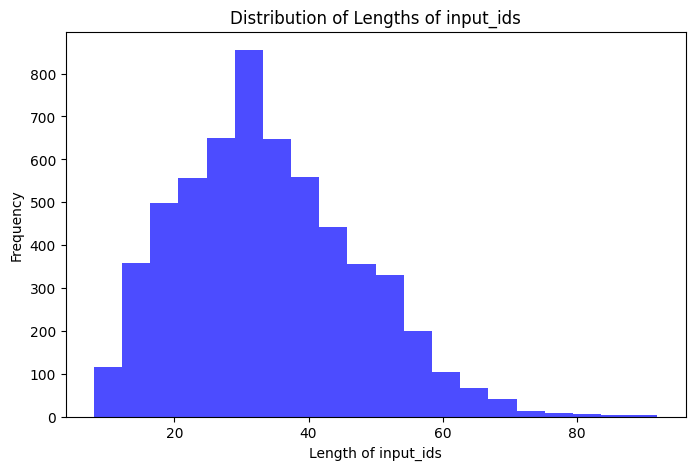

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(8, 5))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

# Tokenize the datasets
tokenized_train_dataset = train_dataset.map(tokenize, batched=True)
tokenized_val_dataset = eval_dataset.map(tokenize, batched=True)

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

we will find that 340 is a good estimate of max length. We will include padding and truncation into the `tokenization` routine:

In [ ]:
max_length = 340 # This was an appropriate max length for my dataset

# redefine the tokenize function and tokenizer

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token


def tokenize(prompt):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

And now, let's assemble the prompts for fine tuning:

In [ ]:
def generate_and_tokenize_prompt(data_point):
    full_prompt =f"""Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
{data_point["target"]}

### Meaning representation:
{data_point["meaning_representation"]}
"""
    return tokenize(full_prompt)

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/714 [00:00<?, ? examples/s]

5817


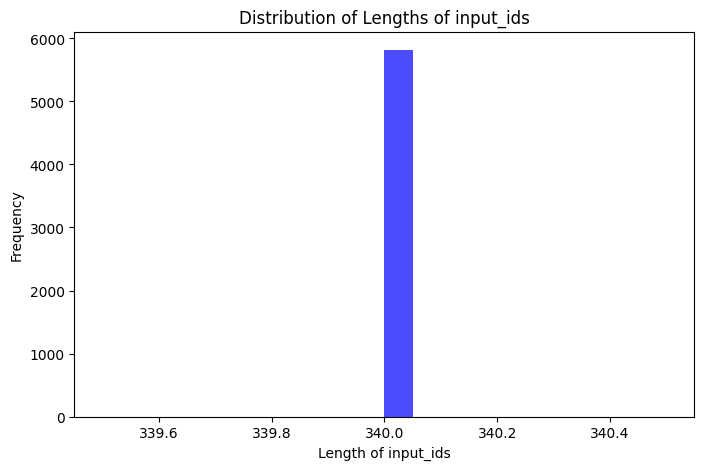

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

## Running the model for the first time

Now, let's try to apply Mixtral!

In [ ]:
eval_prompt = """Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
Earlier, we stated that we didn't have strong feelings about PlayStation's Little Big Adventure. Is our opinion true for all games which don't have multiplayer?

### Meaning representation:
"""

We can apply accelerator to the model. If we're using colab, it can start raising stupid errors like

```
TypeError: device() received an invalid combination of arguments - got (NoneType), but expected one of:
 * (torch.device device)
      didn't match because some of the arguments have invalid types: (!NoneType!)
 * (str type, int index)

```

Most likely, we'll be able to overcome it by running

`model.hf_device_map = {'': torch.device('cuda', index=0)}`

In [ ]:
# Apply the accelerator. we can comment this out to remove the accelerator.
# model = accelerator.prepare_model(model)
model.hf_device_map = {'': torch.device('cuda', index=0)}

In [ ]:
# Re-init the tokenizer so it doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

In [ ]:
device = "cuda"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to(device)

In [ ]:
model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=128)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
Earlier, you stated that you didn't have strong feelings about PlayStation's Little Big Adventure. Is your opinion true for all games which don't have multiplayer?

### Meaning representation:
inform(name(Little Big Adventure), has_multiplayer(Little Big Adventure))

### Target sentence:
I'm looking for a game that is av

we can see that the model doesn't understand which formatting we are expecting from it. We will try to improve it with fine tuning.

## Investigating Mixtral heads

**Task 3.3.** Apply Mixtral to some sentence

`router_logits = model(**model_input, output_router_logits=True)`

to make it return router logits that decide which heads are used for inference.

Do the logits stay the same when we apply Mixtral several times to the same sentence? Why?

Now:
- get router logits of 10th, 20th and 30th layers for the first 100 elements of `tokenized_train_dataset`.
- For each expert of each of these layers, make a list of tokens for which this expert has top-1 logit (yes, please do it separately for each of the experts),
- Output top-5 most frequent tokens from each of the lists.

our output should be like:

```
At layer 20:

Expert 0:
[('token1', how_many_times_expert_0_got_top1_router_logit_with_this_token),
('token2', how_many_times_expert_0_got_top1_router_logit_with_this_token),
('token3', how_many_times_expert_0_got_top1_router_logit_with_this_token),
('token4', how_many_times_expert_0_got_top1_router_logit_with_this_token),
('token5', how_many_times_expert_0_got_top1_router_logit_with_this_token),]

Expert 1
....
```

Do we observe any patterns?

In [ ]:
from collections import defaultdict, Counter
import torch

# Initialize a dictionary to store the tokens for each expert
expert_tokens = defaultdict(list)

# Loop over the first 100 elements of the tokenized_train_dataset
for i in range(100):
    # Get the input for the model
    model_input = tokenized_train_dataset[i]

    # Remove unnecessary keys from the model input
    for key in ['gem_id', 'meaning_representation', 'target', 'references']:
        if key in model_input:
            del model_input[key]

    # Convert input_ids, attention_mask, and labels to tensors if they're lists
    # Add the batch dimension if it's missing
    for key in ['input_ids', 'attention_mask', 'labels']:
        if isinstance(model_input.get(key), list):
            model_input[key] = torch.tensor(model_input[key])
        if len(model_input.get(key).shape) == 1:
            model_input[key] = model_input[key].unsqueeze(0)

    # Iterate over all layers in router_logits
    for layer in range(len(router_logits)):
        # Get the logits for this layer
        logits = router_logits[layer]

        # Check if logits is not a 0-dimensional tensor
        if isinstance(logits, tuple):
            for tensor in logits:
                if isinstance(tensor, torch.Tensor) and tensor.dim() > 0:
                    for expert in range(tensor.shape[-1]):
                        # Get the tokens where this expert has the top-1 logit
                        top1_indices = tensor[..., expert].argmax(-1)

                        # Check if the top1_indices are within the range of the tensor
                        if top1_indices < model_input['input_ids'].shape[0]:
                            top1_tokens = model_input['input_ids'][top1_indices]

                            # Add these tokens to the list for this expert
                            expert_tokens[(layer, expert)].extend(top1_tokens.tolist())
                        else:
                            print(f"Index {top1_indices} is out of range. Skipping this index.")
                else:
                    print("Tensor is not a tensor or is a scalar, skipping this loop.")
        else:
            if logits.dim() > 0:
                print("Logits is a scalar, skipping this loop.")

# For each expert, count the frequency of each token and get the top-5 most frequent tokens
for (layer, expert), tokens in expert_tokens.items():
    token_counts = Counter(tokens)
    top5_tokens = token_counts.most_common(5)

    print(f"At layer {layer}:\n")
    print(f"Expert {expert}:")
    for token, count in top5_tokens:
        print(f"('{eval_tokenizer.decode([token])}', {count})")
    print("\n")

Logits is a scalar, skipping this loop.
Logits is a scalar, skipping this loop.
Logits is a scalar, skipping this loop.
Logits is a scalar, skipping this loop.
Logits is a scalar, skipping this loop.
Logits is a scalar, skipping this loop.
Logits is a scalar, skipping this loop.
Logits is a scalar, skipping this loop.
Logits is a scalar, skipping this loop.
Logits is a scalar, skipping this loop.
Logits is a scalar, skipping this loop.
Logits is a scalar, skipping this loop.
Logits is a scalar, skipping this loop.
Logits is a scalar, skipping this loop.
Logits is a scalar, skipping this loop.
Logits is a scalar, skipping this loop.
Logits is a scalar, skipping this loop.
Logits is a scalar, skipping this loop.
Logits is a scalar, skipping this loop.
Logits is a scalar, skipping this loop.
Logits is a scalar, skipping this loop.
Logits is a scalar, skipping this loop.
Logits is a scalar, skipping this loop.
Logits is a scalar, skipping this loop.
Logits is a scalar, skipping this loop.


## Set Up LoRA

We will be fine tuning our model with LoRA. To start, we have to apply some preprocessing to the model to prepare it for training. For that use the prepare_model_for_kbit_training method from PEFT.

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

Now, we'll define which layers are subject to fine tuning and understand how many trainable parameters we are going to have.

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "w1",
        "w2",
        "w3",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)


In [ ]:
model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 120350720 || all params: 23602952192 || trainable%: 0.5098968934945001


As we see, only a small ratio of parameters are trainable.

Let's look closer at the config.

* `r` is the rank of the low-rank matrix used in the adapters. The larger it is, the more trainable parameters we have, so the more expressive the model is, but also the more compute we need for fine tuning. We set `r = 8` which is a reasonable default value.
* `lora_alpha` is the scaling factor for the learned weights. The weight matrix $\Delta W$ is scaled by `lora_alpha/r`, and thus a higher value for alpha assigns more weight to the LoRA activations. We use `lora_alpha = 16` which is also a reasonable default.


The trainable layers are indicated by their codes "q_proj", "k_proj", "v_proj", "o_proj", "w1", "w2", "w3", "lm_head". Here,

* "q_proj", "k_proj", "v_proj" are $W_Q, W_K, W_V$ matrices making queries, keys and values from transformer layer inputs like in $q = xW_Q$.
* "o_proj" is the output projection matrix $W_o$ that comes at the final step of QKV-attention mechanism. For the linearized attention mechanism it would look like this:
$$o_n = \sum_{m=1}^N\frac{\left(\psi(q_n)R^d_{\Theta, n}\right)\left(\phi(k_m)R^d_{\Theta, m}\right)^T}{\sum_{m=1}^N\psi(q_n)\phi(k_m)^T}v_m,$$
$$\quad$$
$$output = oW_o,$$
* "lm_head" is the language modeling head that goes after the last transformer block and predicts next token logits.

It is reasonable that we don't fine tune the embedding layer. It is only reasonable to train it if we introduce new tokens (for example, if we want to adapt our model to new languages), and in this case we only train the embeddings of newly added tokens.

**Task 3.4.** Now, we have a quest for we. The labels "w1", "w2" and "w3" stand for the linear layers inside each of the experts (who are just MLPs). But how are they connected to each other? What is the architecture of this MLP?

It's not addressed well in the Mixtral/Mistral papers (feel free to check though, maybe the author of this hometask wasn't attentive enough), so our best chance to grasp it is finding the source code in the Transformers library.

The labels "w1", "w2", and "w3" represent the weights of the linear layers in each expert of the Mixture of Experts (MoE) model. In the context of the MixtralForCausalLM model, each expert is a MixtralBlockSparseTop2MLP module, which is a type of multi-layer perceptron (MLP).

The architecture of this MLP can be inferred from the model structure:

MixtralBlockSparseTop2MLP(
  (w1): Linear4bit(in_features=4096, out_features=14336, bias=False)
  (w2): Linear4bit(in_features=14336, out_features=4096, bias=False)
  (w3): Linear4bit(in_features=4096, out_features=14336, bias=False)
  (act_fn): SiLU()
)

The input to the MLP is a vector of size 4096 (as indicated by in_features=4096 in the w1 layer).

This input is passed through the w1 layer, which is a linear layer that transforms the input vector from size 4096 to size 14336.

The output of the w1 layer is then passed through the activation function (act_fn), which is a Scaled Exponential Linear Unit (SiLU).

The activated output is then passed through the w2 layer, which is another linear layer that transforms the vector from size 14336 back to size 4096.

The output of the w2 layer is again passed through the activation function.

Finally, the activated output is passed through the w3 layer, which is a third linear layer that transforms the vector from size 4096 back to size 14336.

This forms a three-layer MLP with sizes 4096-14336-4096-14336. The use of the SiLU activation function between the layers adds non-linearity, allowing the MLP to model more complex functions.

## Run Training

Fine tuning can take some time. However, we can stop training earlier (say, after 100-500 steps) if we observe overfitting or are just tired of waiting. Thought, the result can be not so great.

In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
torch.cuda.device_count() # should be 4 if using Brev's instance link

1

In [ ]:
import transformers
from datetime import datetime

project = "viggo-finetune"
base_model_name = "mixtral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=5,
        per_device_train_batch_size=1,
        gradient_checkpointing=True,
        gradient_accumulation_steps=4,
        max_steps=1000,
        learning_rate=2.5e-5,
        logging_steps=25,
        fp16=True,
        optim="paged_adamw_8bit",
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=50,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=50,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        # report_to="wandb",           # Comment this out if we don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


**Task 3.5.** Run the training!

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
50,0.372100,0.318896
100,0.269800,0.241046
150,0.220300,0.208178
200,0.200300,0.194138
250,0.183300,0.185336
300,0.178900,0.179672
350,0.167200,0.176036
400,0.180700,0.173043
450,0.180200,0.171637
500,0.152200,0.168480


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in

TrainOutput(global_step=1000, training_loss=0.21224154019355773, metrics={'train_runtime': 15069.2305, 'train_samples_per_second': 0.265, 'train_steps_per_second': 0.066, 'total_flos': 3.8100730281984e+17, 'train_loss': 0.21224154019355773, 'epoch': 0.78})

Note that while training the model will save the adapter weights each 50 steps (`save_steps` param) in the folders like "mixtral-viggo-finetune/checkpoint-50", "mixtral-viggo-finetune-2/checkpoint-100" etc. This way, we'll be able to restore the trained model later.

## Try the model

At this point, we recommend we to restart the kernel to avoid running into out of memory problems.

To reload the model, we need to do two things:

1. Load the base model,
2. Load the adapter weights that oure saved in the checkpoints.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mixtral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    trust_remote_code=True,
)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [ ]:
from peft import PeftModel

# Insert correct checkpoint index, double check the path
ft_model = PeftModel.from_pretrained(base_model, "mixtral-viggo-finetune/checkpoint-1000")

Now, let's run the model and see if it learnt to abide the required format:

In [ ]:
eval_prompt = """Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
Earlier, we stated that we didn't have strong feelings about PlayStation's Little Big Adventure. Is our opinion true for all games which don't have multiplayer?

### Meaning representation:
"""

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=50)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
Earlier, you stated that you didn't have strong feelings about PlayStation's Little Big Adventure. Is your opinion true for all games which don't have multiplayer?

### Meaning representation:
 /******/ /***/ /***/ ###### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### ### 

In [ ]:
model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=128)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Given a target sentence construct the underlying meaning representation of the input sentence as a single function with attributes and attribute values.
This function should describe the target string accurately and the function must be one of the following ['inform', 'request', 'give_opinion', 'confirm', 'verify_attribute', 'suggest', 'request_explanation', 'recommend', 'request_attribute'].
The attributes must be one of the following: ['name', 'exp_release_date', 'release_year', 'developer', 'esrb', 'rating', 'genres', 'player_perspective', 'has_multiplayer', 'platforms', 'available_on_steam', 'has_linux_release', 'has_mac_release', 'specifier']

### Target sentence:
Earlier, you stated that you didn't have strong feelings about PlayStation's Little Big Adventure. Is your opinion true for all games which don't have multiplayer?

### Meaning representation:
verify_attribute(name[Little Big Adventure], rating[average], has_multiplayer[no], platforms[PlayStation])

### Target sentence:


### Observations and reflections

From the results, it appears that fine-tuning the Mixtral model has led to more detailed and potentially more accurate meaning representations.

Without fine-tuning, the model seems to generate simpler meaning representations. For example, in response to the sentence about "Little Big Adventure", it generates "inform(name(Little Big Adventure), has_multiplayer(Little Big Adventure))". This representation is quite basic and may not fully capture the nuances of the input sentence.

With fine-tuning, the model generates more complex meaning representations. For the same sentence about "Little Big Adventure", it generates "verify_attribute(name[Little Big Adventure], rating[average], has_multiplayer[no], platforms[PlayStation])". This representation includes more attributes and seems to better capture the nuances of the input sentence.

For the sentence "I'm curious, have we ever played a game that we thought was just average?", both the fine-tuned and non-fine-tuned model generate the same representation: "request(specifier[average])". This suggests that for some sentences, fine-tuning may not make a significant difference.

Overall, it seems that fine-tuning the Mixtral model can lead to more detailed and potentially more accurate meaning representations. However, the effectiveness of fine-tuning may depend on the specific sentences and the complexity of their meaning.

Do this instead of Task 3 if Mixtral doesn't fit on our GPU

If we can't approach Mixtral, we will do almost the same with Mistral. Mistral is much less compute intensive and fits well on V100.

In what concerns fine tuning, the only thing we need is to change `model_id` to `"mistralai/Mistral-7B-v0.1"`. All the code should work without trouble. Just **please indicate in bold in the beginning of Task 3 that we're using Mistral instead of Mixtral**.

**Tasks 3.1, 3.2, 3.4, and 3.5** stay the same. Moreover, the answers won't change much, because Mixtral inherits Mistral's architectural ideas.

Task 3.3 doean't make sense with Mistral, so instead we'll do the following:

**Task 4.3.** Fine tuning Mistral is faster than fine tuning Mixtral, so we can run several experiments (but try to reach at least 500 steps). Train only attention layers with QLoRA. How will the number of trainable parameters change? Compare the quality of the resulting model.